In [ ]:
pip install qiskit qiskit_aer

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import *
from numpy import pi
import numpy as np
import math
from qiskit_aer import Aer
from qiskit import transpile
import qiskit.quantum_info as qi
import random
from qiskit.circuit.library import SdgGate
import matplotlib.pyplot as plt

In [ ]:
length=128
DitSequence= [random.randint(0, 3) for _ in range(length)]
AliceBases =[random.randint(0, 1) for _ in range(length)]
BobBases = [random.randint(0, 1) for _ in range(length)]
EveBases = [random.randint(0, 1) for _ in range(length)]

In [ ]:
# All Qudit related functions and objects

def base4_sort(key):
    return int(key, 4)
class QuditCircuit:
    def __init__(self, d, n):
        # Calculate the total number of qubits
        self.num_qudits = n
        self.dimension = d
        self.num_qubits = n * d/2
        self.Counts = []
        self.Counts2 = []
        # Create a QuantumCircuit object with the specified dimensions
        self.circuit = QuantumCircuit(self.num_qubits, self.num_qubits)
    def measure(self):
        # Add a barrier to separate the measurement operations
        self.circuit.barrier()
        # Measure all qubits
        qubit_indices = list(range(int(self.num_qubits)))
        self.circuit.measure(qubit_indices, qubit_indices)
    def CT(self,Gate):
      CT_Gate = qi.Operator(Gate)
      for i in range(0, int(self.num_qubits), 2):
        self.circuit.unitary(CT_Gate, [i,i+1], label="CrossTalk")
    def Translate(self):
      # Translate each key into the desired format
      translated_data = {}
      for key, value in self.Counts.items():
          translated_key = ''.join([str(int(key[i:i+2], 2)) for i in range(0, len(key), 2)])
          translated_data[translated_key] = value
      sorted_data = {k: v for k, v in sorted(translated_data.items(), key=lambda item: base4_sort(item[0]))}
      self.Counts2 = sorted_data
    def run(self):
      # Use Aer's qasm_simulator
      simulator = Aer.get_backend('qasm_simulator')
      # Execute the circuit on the qasm simulator
      new_circuit = transpile(self.circuit, simulator)
      job = simulator.run(new_circuit, shots = 1000)
      # Grab results from the job
      result = job.result()
      # Return counts
      self.Counts = result.get_counts(self.circuit)
      self.Translate()
    def test(self):
      self.circuit.x(1)

In [ ]:
# Here are all the functions related to BB84 protocol

def Modulation(Qudit,Dit,AliceBasis):
  if AliceBasis == 0:
    #print("Basis 0")
    if Dit == 1:
      Qudit.circuit.x(0)
    if Dit == 2:
      Qudit.circuit.x(1)
    if Dit == 3:
      Qudit.circuit.x(0)
      Qudit.circuit.x(1)
  else:
     #print("Basis 1")
     if Dit == 0:
      #print("Entered 0")
      Qudit.circuit.h(0)
      Qudit.circuit.h(1)
     elif Dit == 1:
      #print("Entered 1")
      Qudit.circuit.x(1)
      Qudit.circuit.h(1)
      Qudit.circuit.h(0)
      Qudit.circuit.s(0)
     elif Dit == 2:
      #print("Entered 2")
      Qudit.circuit.x(0)
      Qudit.circuit.h(0)
      Qudit.circuit.h(1)
     elif Dit == 3:
      #print("Entered 3")
      Qudit.circuit.x(0)
      Qudit.circuit.h(0)
      Qudit.circuit.s(0)
      Qudit.circuit.x(1)
      Qudit.circuit.h(1)
  return Qudit
def ReciviengSinglePhoton(Qudit,BobBasis):
  csgate = SdgGate().control(1) # the parameter is the amount of control points you want
  if BobBasis == 1:
     #print("Measure Basis 1")
     Qudit.circuit.h(1)
     Qudit.circuit.append(csgate, [1, 0])
     Qudit.circuit.h(0)
     Qudit.circuit.cx(1,0)
     Qudit.circuit.cx(0,1)
     Qudit.circuit.cx(1,0)
  Qudit.measure()
  Qudit.run()
  #print(Qudit.Counts)
def CrossTalk(Qudit):
  Gate = [[0.9,math.sqrt(19/100)*1j,0,0],
        [math.sqrt(19/100)*1j,0.9,0,0],
        [0,0,0.9,math.sqrt(19/100)*1j],
        [0,0,math.sqrt(19/100)*1j,0.9]]
  Qudit.CT(Gate)
def BB84(DitSequence,AliceBases,BobBases,EveBases,length,Eve,CrossT):
   ListOfCounts = []
   if Eve==True:
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,EveBases[i])
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
    output_string = ""
    for d in ListOfCounts:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
    list_from_Key = [int(char) for char in output_string]
    ListOfCounts = []
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],EveBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,BobBases[i])
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
        #print("-----------")
    Check_list = []
    for i in range(len(ListOfCounts)):
       if AliceBases[i] == BobBases[i]:
           Check_list.append(ListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string = ""
    for d in Check_list:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
   else:
    for i in range(length):
        #print("for bit number : ", i)
        Qudit = QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        CrossTalk(Qudit) if CrossT else None
        #Recive Single Photon
        ReciviengSinglePhoton(Qudit,BobBases[i])
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
        #print("-----------")
    Check_list = []
    for i in range(len(ListOfCounts)):
       if AliceBases[i] == BobBases[i]:
           Check_list.append(ListOfCounts[i])
   #print("The Bases checked list is : ",Check_list)
    output_string = ""
    for d in Check_list:
     key = list(d.keys())[0]  # Extract the key from the dictionary
     output_string += key
   return  output_string
def AliceKey(Dit,AliceBases,BobBases):
    Check_list = []
    for i in range(len(Dit)):
        if AliceBases[i] == BobBases[i]:
            Check_list.append(Dit[i])
        Key = ''
    for item in Check_list:
        Key = Key + str(item)
    return Key
def CheckSecurity(Key,Akey,Checklength):
    if Akey[-Checklength:] == Key[-Checklength:]:
        print("The Connection is Secure with the probability of:")
        print((1-((3/4)**Checklength))*100)
    else:
        print("The Connection is not Secure!")

#This Functions are for analizing our results
def calculate_error_rate(results, alicekey):
    error_rates = []
    sums = 0
    results_length = len(results)
    key_length = len(alicekey)

    for result in results:
        # Compare each character in the strings and count the number of differences
        num_errors = sum(bit1 != bit2 for bit1, bit2 in zip(result, alicekey))
        # Calculate the error rate
        error_rate = num_errors / key_length
        sums = sums + error_rate
        error_rates.append(error_rate)

    return error_rates , sums/results_length

In [ ]:
Key = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True)
EveKey = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,True)
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)

In [ ]:
print("Bob's Key is: ",Key)
print("Alice's Key is : ",aliceKey)
print("Bob's Key is(Eve): ",EveKey)

Bob's Key is:  120121211012232201020020000220220000021010022200222222300
Alice's Key is :  130121211012232311021020110230220000121010032211222223310
Bob's Key is(Eve):  000021211000202000020000000220200000001010002200002000000


In [ ]:
CheckSecurity(Key,aliceKey,30)

The Connection is not Secure!


In [ ]:
print(len(Key))

31


In [ ]:
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
results = []
for _ in range(30):
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,False,True) # Call the BB84 function
   results.append(result)
print(results)

['32223223102030301310223110213321232', '32223223102030301310223100213320232', '32223223112030301310223010213320232', '32223223102030301301222100213321232', '32323223102030301310222110213321232', '32223223102030301300222110313331232', '22323223102030301310223110213321232', '32223223102030301310222110213320222', '32223223102030301300223010213320232', '32223223102030301310222110213321232', '32223223112030301200233110213321232', '32223223112030301310223010213320222', '32223223112030301310223110213321232', '22223223102030301301223100213321232', '32223223102030301310223110213321232', '32223223112030301311223110213320232', '32223223102030301310233110313321222', '32223223102030301210233100213321232', '32223223102030301210223110213321232', '32223223102030301310233110213331232', '32223223102030301200223000213321232', '32223223102030301311223110313331232', '22223223102030301310232110213321232', '32223223102030301300223110313321232', '32223223102030301311223110213321222', '32223223102030301310222

In [ ]:
error_rates , average = calculate_error_rate(results, aliceKey)
print("Error rates:", error_rates)
print("Average of error : ", average)

Error rates: [0.0, 0.05714285714285714, 0.08571428571428572, 0.11428571428571428, 0.05714285714285714, 0.11428571428571428, 0.05714285714285714, 0.08571428571428572, 0.08571428571428572, 0.02857142857142857, 0.11428571428571428, 0.11428571428571428, 0.02857142857142857, 0.11428571428571428, 0.0, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.02857142857142857, 0.05714285714285714, 0.11428571428571428, 0.08571428571428572, 0.08571428571428572, 0.05714285714285714, 0.05714285714285714, 0.08571428571428572, 0.02857142857142857, 0.11428571428571428, 0.11428571428571428, 0.08571428571428572]
Average of error :  0.07428571428571427


In [ ]:
aliceKey= AliceKey(DitSequence,AliceBases,BobBases)
Everesults = []
for _ in range(10):
   result = BB84(DitSequence,AliceBases,BobBases,EveBases,length,True,False) # Call the BB84 function
   Everesults.append(result)

In [ ]:
EveError_rates , EveAverage = calculate_error_rate(Everesults, aliceKey)
print("Error rates:", EveError_rates)
print("Average of error : ", EveAverage)

Error rates: [0.2857142857142857, 0.2698412698412698, 0.30158730158730157, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333, 0.31746031746031744, 0.36507936507936506, 0.3492063492063492, 0.30158730158730157]
Average of error :  0.3142857142857143


In [ ]:
def State_Probabilty_Visualization(CrossT):
  ListOfCounts = []
  Dits = [0,1,2,3]
  SenderBasis = [0,1]
  ReciverBasis = [0,1]
  for SBasis in SenderBasis:
    for  Dit in Dits:
      for RBasis in ReciverBasis:
        Qudit = QuditCircuit(4,1)
        Qudit = Modulation(Qudit,Dit,SBasis)
        CrossTalk(Qudit) if CrossT else None
        ReciviengSinglePhoton(Qudit,RBasis)
        counts = Qudit.Counts2
        for key in counts:
          counts[key] /= 1000
        for NDit in Dits:
          if str(NDit) not in counts:
            counts[str(NDit)] = 0.0
        ListOfCounts.append(counts)
  propmatrix = np.zeros((8,8))
  j = 0
  k = 0
  for i in ListOfCounts:
    propmatrix[k,j]= i['0']
    propmatrix[k,j+1] = i['1']
    propmatrix[k,j+2]= i['2']
    propmatrix[k,j+3] = i['3']
    j += 4
    if j >= 8 :
      j = 0
      k += 1
  return propmatrix

In [ ]:
propmat = State_Probabilty_Visualization(True)

In [ ]:
print(propmat)

[[0.806 0.194 0.    0.    0.24  0.447 0.247 0.066]
 [0.193 0.807 0.    0.    0.261 0.05  0.22  0.469]
 [0.    0.    0.803 0.197 0.254 0.46  0.23  0.056]
 [0.    0.    0.175 0.825 0.24  0.057 0.258 0.445]
 [0.237 0.261 0.284 0.218 1.    0.    0.    0.   ]
 [0.051 0.478 0.062 0.409 0.    0.82  0.    0.18 ]
 [0.234 0.229 0.24  0.297 0.    0.    1.    0.   ]
 [0.47  0.06  0.408 0.062 0.    0.179 0.    0.821]]


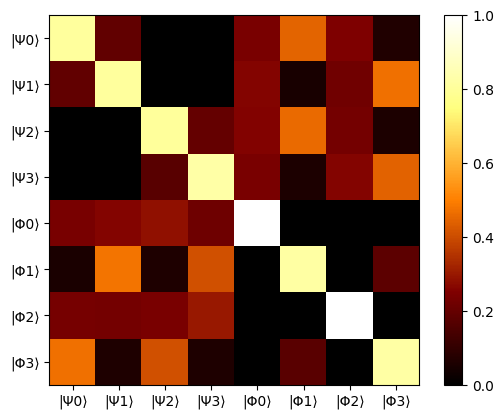

In [ ]:
# Plot the heatmap
plt.imshow(propmat, cmap='afmhot', interpolation='nearest')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=["|Ψ0⟩", "|Ψ1⟩", "|Ψ2⟩", "|Ψ3⟩" ,"|Φ0⟩", "|Φ1⟩","|Φ2⟩", "|Φ3⟩"])
# Add color bar
plt.colorbar()

# Show the plot
plt.show()

In [ ]:
circuit =  QuantumCircuit(2,2)
circuit.x(1)
circuit.h(1)
circuit.x(0)
circuit.h(0)
circuit.s(0)
# ---- MEAsure
csgate = SdgGate().control(1)
circuit.h(1)
circuit.append(csgate, [1, 0])
circuit.h(0)
circuit.cx(1,0)
circuit.cx(0,1)
circuit.cx(1,0)
circuit.measure([0,1], [0,1])
simulator = Aer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator
new_circuit = transpile(circuit, simulator)
job = simulator.run(new_circuit, shots = 1000)
# Grab results from the job
result = job.result()
# Return count
Counts = result.get_counts(circuit)

In [ ]:
print(Counts)

{'11': 1000}
